In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

def mnist_dataset():
    (x, y), _ = datasets.mnist.load_data()
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    ds = ds.map(prepare_mnist_features_and_labels)
    ds = ds.take(20000).shuffle(20000).batch(100)
    return ds

def prepare_mnist_features_and_labels(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    y = tf.cast(y, tf.int64)
    return x, y

# Fully-connected Network

In [3]:
model = keras.Sequential([
    layers.Reshape(target_shape=(28 * 28,), input_shape=(28, 28)),
    layers.Dense(100, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(10)])

optimizer = optimizers.Adam()

In [4]:
@tf.function
def compute_loss(logits, labels):
    return tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=logits, labels=labels))

@tf.function
def compute_accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))

@tf.function
def train_one_step(model, optimizer, x, y):
    with tf.GradientTape() as tape:
        logits = model(x)
        loss = compute_loss(logits, y)
        
        # compute gradient
        grads = tape.gradient(loss, model.trainable_variables)
        # update to weights
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        accuracy = compute_accuracy(logits, y)

    # loss and accuracy is scalar tensor
    return loss, accuracy

def train(epoch, model, optimizer):
    train_ds = mnist_dataset()
    loss = 0.0
    accuracy = 0.0
    for step, (x, y) in enumerate(train_ds):
        loss, accuracy = train_one_step(model, optimizer, x, y)

        if step % 500 == 0:
            print('epoch', epoch, ': loss', loss.numpy(), '; accuracy', accuracy.numpy())

    return loss, accuracy

In [5]:
for epoch in range(20):
    loss, accuracy = train(epoch, model, optimizer)

print('Final epoch', epoch, ': loss', loss.numpy(), '; accuracy', accuracy.numpy())

epoch 0 : loss 2.3122826 ; accuracy 0.11
epoch 1 : loss 0.14781065 ; accuracy 0.96
epoch 2 : loss 0.1957429 ; accuracy 0.91
epoch 3 : loss 0.12940712 ; accuracy 0.94
epoch 4 : loss 0.04160511 ; accuracy 0.99
epoch 5 : loss 0.06092364 ; accuracy 0.99
epoch 6 : loss 0.02905951 ; accuracy 0.99
epoch 7 : loss 0.12544249 ; accuracy 0.95
epoch 8 : loss 0.01791113 ; accuracy 1.0
epoch 9 : loss 0.0038799262 ; accuracy 1.0
epoch 10 : loss 0.017705748 ; accuracy 1.0
epoch 11 : loss 0.02343543 ; accuracy 0.99
epoch 12 : loss 0.0103632165 ; accuracy 1.0
epoch 13 : loss 0.015506345 ; accuracy 0.99
epoch 14 : loss 0.0051391716 ; accuracy 1.0
epoch 15 : loss 0.0034456858 ; accuracy 1.0
epoch 16 : loss 0.009956448 ; accuracy 1.0
epoch 17 : loss 0.0031556296 ; accuracy 1.0
epoch 18 : loss 0.0030086457 ; accuracy 1.0
epoch 19 : loss 0.001498969 ; accuracy 1.0
Final epoch 19 : loss 0.0009759335 ; accuracy 1.0


In [12]:
# load dataset create predictions on the test set
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
ds = ds.map(prepare_mnist_features_and_labels)

predicted_classes = model.predict_classes(x_test)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


9707  classified correctly
293  classified incorrectly


In [30]:
len(correct_indices) / (len(predicted_classes))

0.9707

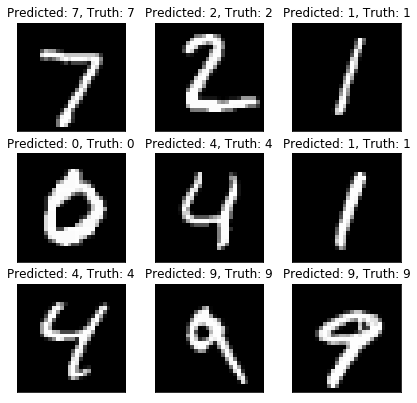

In [18]:
# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

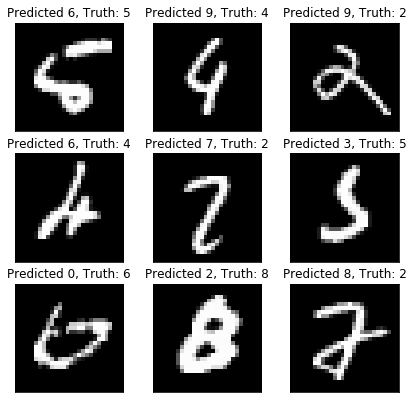

In [21]:
# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

# Convolutional Network

In [23]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.python.ops import summary_ops_v2
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, optimizers, metrics

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}


def mnist_datasets():
    (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
    # Numpy defaults to dtype=float64; TF defaults to float32. Stick with float32.
    x_train, x_test = x_train / np.float32(255), x_test / np.float32(255)
    y_train, y_test = y_train.astype(np.int64), y_test.astype(np.int64)
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    return train_dataset, test_dataset

In [24]:
train_ds, test_ds = mnist_datasets()
train_ds = train_ds.shuffle(60000).batch(100)
test_ds = test_ds.batch(100)

In [25]:
model = tf.keras.Sequential([
    layers.Reshape(
        target_shape=[28, 28, 1],
        input_shape=(28, 28,)),
    layers.Conv2D(2, 5, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    layers.Conv2D(4, 5, padding='same', activation=tf.nn.relu),
    layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(32, activation=tf.nn.relu),
    layers.Dropout(rate=0.4),
    layers.Dense(10)])

optimizer = optimizers.SGD(learning_rate=0.01, momentum=0.5)

In [26]:
compute_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
compute_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

def train_step(model, optimizer, images, labels):

    # Record the operations used to compute the loss, so that the gradient
    # of the loss with respect to the variables can be computed.
    with tf.GradientTape() as tape:
        logits = model(images, training=True)
        loss = compute_loss(labels, logits)
        compute_accuracy(labels, logits)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss

def train(model, optimizer, dataset, log_freq=50):
    """
    Trains model on `dataset` using `optimizer`.
    """
    # Metrics are stateful. They accumulate values and return a cumulative
    # result when you call .result(). Clear accumulated values with .reset_states()
    avg_loss = metrics.Mean('loss', dtype=tf.float32)

    # Datasets can be iterated over like any other Python iterable.
    for images, labels in dataset:
        loss = train_step(model, optimizer, images, labels)
        avg_loss(loss)

        if tf.equal(optimizer.iterations % log_freq, 0):
            # summary_ops_v2.scalar('loss', avg_loss.result(), step=optimizer.iterations)
            # summary_ops_v2.scalar('accuracy', compute_accuracy.result(), step=optimizer.iterations)
            print('step:', int(optimizer.iterations),
                  'loss:', avg_loss.result().numpy(),
                  'acc:', compute_accuracy.result().numpy())
            avg_loss.reset_states()
            compute_accuracy.reset_states()

def test(model, dataset, step_num):
    """
    Perform an evaluation of `model` on the examples from `dataset`.
    """
    avg_loss = metrics.Mean('loss', dtype=tf.float32)

    for (images, labels) in dataset:
        logits = model(images, training=False)
        avg_loss(compute_loss(labels, logits))
        compute_accuracy(labels, logits)

    print('Model test set loss: {:0.4f} accuracy: {:0.2f}%'.format(
        avg_loss.result(), compute_accuracy.result() * 100))

    print('loss:', avg_loss.result(), 'acc:', compute_accuracy.result())
    # summary_ops_v2.scalar('loss', avg_loss.result(), step=step_num)
    # summary_ops_v2.scalar('accuracy', compute_accuracy.result(), step=step_num)

In [27]:
# Where to save checkpoints, tensorboard summaries, etc.
MODEL_DIR = '/tmp/tensorflow/mnist'


def apply_clean():
    if tf.io.gfile.exists(MODEL_DIR):
        print('Removing existing model dir: {}'.format(MODEL_DIR))
        tf.io.gfile.rmtree(MODEL_DIR)


apply_clean()

checkpoint_dir = os.path.join(MODEL_DIR, 'checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)

# Restore variables on creation if a checkpoint exists.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [31]:
NUM_TRAIN_EPOCHS = 10

for i in range(NUM_TRAIN_EPOCHS):
    start = time.time()
    #   with train_summary_writer.as_default():
    train(model, optimizer, train_ds, log_freq=500)
    end = time.time()
    print('Train time for epoch #{} ({} total steps): {}'.format(
        i + 1, int(optimizer.iterations), end - start))
    #   with test_summary_writer.as_default():
    #     test(model, test_ds, optimizer.iterations)
    checkpoint.save(checkpoint_prefix)
    print('saved checkpoint.')

export_path = os.path.join(MODEL_DIR, 'export')
tf.saved_model.save(model, export_path)
print('saved SavedModel for exporting.')

step: 3500 loss: 0.28377223 acc: 0.91218
Train time for epoch #1 (3600 total steps): 23.26662850379944
saved checkpoint.
step: 4000 loss: 0.2680242 acc: 0.91614
Train time for epoch #2 (4200 total steps): 22.813820123672485
saved checkpoint.
step: 4500 loss: 0.24334627 acc: 0.92176
Train time for epoch #3 (4800 total steps): 23.23741054534912
saved checkpoint.
step: 5000 loss: 0.24220166 acc: 0.92228
Train time for epoch #4 (5400 total steps): 23.28403377532959
saved checkpoint.
step: 5500 loss: 0.2355132 acc: 0.92748
step: 6000 loss: 0.22779463 acc: 0.92948
Train time for epoch #5 (6000 total steps): 23.440163135528564
saved checkpoint.
step: 6500 loss: 0.21894982 acc: 0.9319
Train time for epoch #6 (6600 total steps): 23.209276914596558
saved checkpoint.
step: 7000 loss: 0.21226624 acc: 0.93428
Train time for epoch #7 (7200 total steps): 23.692888021469116
saved checkpoint.
step: 7500 loss: 0.20354074 acc: 0.93538
Train time for epoch #8 (7800 total steps): 23.308234453201294
saved c